<a href="https://colab.research.google.com/github/shashi913/Adapt_Anti_UAV_detection_system/blob/RF_model/RF_multiclass_classification_model_using_CNN_and_LSTM_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1D U-Net for UAV RF Signal Detection (Binary Classification)
# Dataset: DroneRF
# Task: Detect UAV (1) vs Background/Non-UAV (0)

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import gc

# Install RAR support (run once)
!apt-get install -y unrar
!pip install rarfile
import rarfile

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# CONFIGURATION

In [ ]:
DATASET_PATH = '/content/drive/MyDrive/DroneRF/DroneRF'
OUTPUT_PATH = '/content/drive/MyDrive/DroneRF/DroneRF_processed_IMPROVED'
MODEL_SAVE_PATH = '/content/drive/MyDrive/DroneRF/models_IMPROVED'

os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

LABEL_MAP = {
    'Background RF activites': 0,
    'Phantom drone': 1,
    'AR drone': 2,
    'Bepop drone': 3
}

NUM_CLASSES = 4
DRONE_FOLDERS = ['Phantom drone', 'AR drone', 'Bepop drone']
BACKGROUND_FOLDER = 'Background RF activites'

print(f"Dataset path: {DATASET_PATH}")
print(f"Output path: {OUTPUT_PATH}")
print(f"Model save path: {MODEL_SAVE_PATH}")
print(f"Number of classes: {NUM_CLASSES}")

Dataset path: /content/drive/MyDrive/DroneRF/DroneRF
Output path: /content/drive/MyDrive/DroneRF/DroneRF_processed_IMPROVED
Model save path: /content/drive/MyDrive/DroneRF/models_IMPROVED
Number of classes: 4


# PART 1: DATA EXTRACTION AND PREPROCESSING

In [ ]:
def extract_rar_files(base_path, output_path):
    """Extract all .rar files from the DroneRF dataset"""
    print("\nExtracting RAR files...")
    folders = DRONE_FOLDERS + [BACKGROUND_FOLDER]

    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        if not os.path.exists(folder_path):
            print(f"Warning: {folder_path} not found!")
            continue

        rar_files = glob.glob(os.path.join(folder_path, '*.rar'))

        for rar_file in tqdm(rar_files, desc=f"Extracting {folder}"):
            try:
                with rarfile.RarFile(rar_file) as rf:
                    extract_folder = os.path.join(output_path, folder,
                                                  os.path.splitext(os.path.basename(rar_file))[0])
                    os.makedirs(extract_folder, exist_ok=True)
                    rf.extractall(extract_folder)
            except Exception as e:
                print(f"Error extracting {rar_file}: {e}")

    print("Extraction complete!")


def copy_to_local_storage(drive_path, local_path='/content/data_local'):
    """Copy data from Drive to local Colab storage for 10-100x speedup"""
    print(f"\nCopying data from Drive to local storage...")
    print("This may take a few minutes but will save hours later!")

    if os.path.exists(local_path):
        print(f"Removing existing local data...")
        shutil.rmtree(local_path)

    shutil.copytree(drive_path, local_path)
    print(f"Copy complete! Now using: {local_path}")
    return local_path


def find_csv_files(directory):
    """Recursively find all CSV files"""
    csv_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                csv_files.append(os.path.join(root, file))
    return csv_files


def load_and_pair_segments(csv_files):
    """Load CSV files and pair L and H segments"""
    segments = {}

    for csv_file in csv_files:
        filename = os.path.basename(csv_file)
        if '_' in filename:
            parts = filename.replace('.csv', '').split('_')
            if len(parts) >= 2:
                base_id = parts[0][:-1]  # Remove L/H
                segment_num = parts[1]
                part_type = parts[0][-1]  # L or H

                key = f"{base_id}_{segment_num}"
                if key not in segments:
                    segments[key] = {}
                segments[key][part_type] = csv_file

    return segments

# PART 2: IMPROVED RF SIGNAL PREPROCESSING

In [ ]:
def load_rf_segment_with_fft(l_file, h_file):
    """
    IMPROVED: Load RF segment with frequency domain features

    Returns both time-domain and frequency-domain representations
    """
    try:
        # Load data
        data_l = np.loadtxt(l_file, delimiter=',', dtype=np.float32).flatten()
        data_h = np.loadtxt(h_file, delimiter=',', dtype=np.float32).flatten()
        combined = np.concatenate([data_l, data_h])

        # FIX 1: Use STANDARDIZATION instead of Min-Max normalization
        # This preserves signal power information
        mean_val = np.mean(combined)
        std_val = np.std(combined)
        if std_val > 0:
            time_domain = (combined - mean_val) / std_val
        else:
            time_domain = combined - mean_val

        # FIX 2: Add FREQUENCY DOMAIN features (critical for RF!)
        # Compute FFT to capture frequency characteristics
        fft_features = np.abs(np.fft.rfft(time_domain))

        # Normalize FFT features
        fft_mean = np.mean(fft_features)
        fft_std = np.std(fft_features)
        if fft_std > 0:
            fft_features = (fft_features - fft_mean) / fft_std

        return time_domain, fft_features

    except Exception as e:
        print(f"Error loading segment: {e}")
        return None, None


def augment_rf_signal(signal):
    """
    RF-SPECIFIC DATA AUGMENTATION

    Augments RF signals with domain-appropriate transformations:
    - Additive white noise
    - Amplitude scaling
    - Time shifting
    """
    signal_aug = signal.copy()

    # 1. Add white noise (SNR-aware)
    noise_level = np.random.uniform(0.005, 0.02)
    noise = np.random.normal(0, noise_level, signal.shape)
    signal_aug = signal_aug + noise

    # 2. Amplitude scaling (0.9-1.1x)
    scale = np.random.uniform(0.9, 1.1)
    signal_aug = signal_aug * scale

    # 3. Time shift (circular shift)
    shift = np.random.randint(-100, 100)
    signal_aug = np.roll(signal_aug, shift)

    return signal_aug


def prepare_dataset_with_augmentation(extracted_path, sequence_length=5000,
                                     chunk_size=30, augment_factor=3):
    """
    IMPROVED: Prepare dataset with:
    1. FFT features
    2. Standardization
    3. Data augmentation

    Args:
        extracted_path: Path to extracted data
        sequence_length: Target sequence length (default: 5000)
        chunk_size: Number of segments per chunk
        augment_factor: How many augmented copies per sample (default: 3)
    """
    print("="*70)
    print("IMPROVED RF PREPROCESSING WITH FFT + AUGMENTATION")
    print("="*70)

    # Step 1: Collect all segment paths
    print("\nCollecting all segment pairs...")
    all_segments = []

    for folder_name, label in LABEL_MAP.items():
        folder_path = os.path.join(extracted_path, folder_name)
        if not os.path.exists(folder_path):
            print(f"Warning: {folder_path} not found!")
            continue

        print(f"Scanning {folder_name} (Label {label})...")
        csv_files = find_csv_files(folder_path)
        segments = load_and_pair_segments(csv_files)

        for seg_key, seg_files in segments.items():
            if 'L' in seg_files and 'H' in seg_files:
                all_segments.append((seg_files['L'], seg_files['H'], label))

    total_segments = len(all_segments)
    num_chunks = (total_segments + chunk_size - 1) // chunk_size
    print(f"\nTotal segments: {total_segments}")
    print(f"Processing in {num_chunks} chunks of {chunk_size} segments")
    print(f"Augmentation factor: {augment_factor}x")
    print(f"Expected total samples: {total_segments * augment_factor}")

    # Step 2: Process in chunks and save
    chunk_files = []

    for chunk_idx in range(0, total_segments, chunk_size):
        chunk_end = min(chunk_idx + chunk_size, total_segments)
        chunk_segments = all_segments[chunk_idx:chunk_end]
        chunk_num = chunk_idx // chunk_size

        print(f"\n{'='*70}")
        print(f"Processing chunk {chunk_num + 1}/{num_chunks}")
        print(f"{'='*70}")

        chunk_data_time = []
        chunk_data_freq = []
        chunk_labels = []

        for l_file, h_file, label in tqdm(chunk_segments, desc=f"Chunk {chunk_num + 1}"):
            time_signal, freq_signal = load_rf_segment_with_fft(l_file, h_file)

            if time_signal is not None and freq_signal is not None:
                # Pad or truncate time domain to fixed length
                if len(time_signal) < sequence_length:
                    time_signal = np.pad(time_signal, (0, sequence_length - len(time_signal)), 'constant')
                else:
                    time_signal = time_signal[:sequence_length]

                # Pad or truncate frequency domain
                freq_length = sequence_length // 2 + 1  # Length of rfft output
                if len(freq_signal) < freq_length:
                    freq_signal = np.pad(freq_signal, (0, freq_length - len(freq_signal)), 'constant')
                else:
                    freq_signal = freq_signal[:freq_length]

                # Original sample
                chunk_data_time.append(time_signal)
                chunk_data_freq.append(freq_signal)
                chunk_labels.append(label)

                # 🆕 CREATE AUGMENTED SAMPLES
                for _ in range(augment_factor - 1):  # -1 because we already added original
                    aug_time = augment_rf_signal(time_signal)
                    # Recompute FFT for augmented signal
                    aug_freq = np.abs(np.fft.rfft(aug_time))
                    # Normalize
                    aug_freq = (aug_freq - np.mean(aug_freq)) / (np.std(aug_freq) + 1e-8)
                    aug_freq = aug_freq[:freq_length]

                    chunk_data_time.append(aug_time)
                    chunk_data_freq.append(aug_freq)
                    chunk_labels.append(label)

        # Convert to numpy and save
        chunk_data_time = np.array(chunk_data_time, dtype=np.float32)
        chunk_data_freq = np.array(chunk_data_freq, dtype=np.float32)
        chunk_labels = np.array(chunk_labels, dtype=np.int8)

        # Save chunk
        chunk_file_time = os.path.join(MODEL_SAVE_PATH, f'chunk_{chunk_num}_X_time.npy')
        chunk_file_freq = os.path.join(MODEL_SAVE_PATH, f'chunk_{chunk_num}_X_freq.npy')
        label_file = os.path.join(MODEL_SAVE_PATH, f'chunk_{chunk_num}_y.npy')

        np.save(chunk_file_time, chunk_data_time)
        np.save(chunk_file_freq, chunk_data_freq)
        np.save(label_file, chunk_labels)

        chunk_files.append((chunk_file_time, chunk_file_freq, label_file))

        print(f"Saved chunk {chunk_num + 1}: {chunk_data_time.shape[0]} samples (including augmented)")
        print(f"Memory freed: {(chunk_data_time.nbytes + chunk_data_freq.nbytes) / 1024 / 1024:.2f} MB")

        del chunk_data_time, chunk_data_freq, chunk_labels
        gc.collect()

    print(f"\n{'='*70}")
    print(f"All {num_chunks} chunks saved to {MODEL_SAVE_PATH}")
    print(f"{'='*70}")

    # Step 3: Load all chunks and combine
    print("\nLoading and combining all chunks...")
    all_X_time = []
    all_X_freq = []
    all_y = []

    for chunk_file_time, chunk_file_freq, label_file in tqdm(chunk_files, desc="Loading chunks"):
        X_time_chunk = np.load(chunk_file_time)
        X_freq_chunk = np.load(chunk_file_freq)
        y_chunk = np.load(label_file)

        all_X_time.append(X_time_chunk)
        all_X_freq.append(X_freq_chunk)
        all_y.append(y_chunk)

    # Concatenate
    X_time = np.concatenate(all_X_time, axis=0)
    X_freq = np.concatenate(all_X_freq, axis=0)
    y = np.concatenate(all_y, axis=0)

    del all_X_time, all_X_freq, all_y
    gc.collect()

    # Reshape for model input
    X_time = X_time.reshape(X_time.shape[0], X_time.shape[1], 1)
    X_freq = X_freq.reshape(X_freq.shape[0], X_freq.shape[1], 1)

    print(f"\n{'='*70}")
    print(f"DATASET READY")
    print(f"{'='*70}")
    print(f"Total samples: {X_time.shape[0]}")

    # Print per-class distribution
    for class_name, label in LABEL_MAP.items():
        count = np.sum(y == label)
        print(f"{class_name}: {count} samples ({count/len(y)*100:.1f}%)")

    print(f"\nTime domain shape: {X_time.shape}")
    print(f"Frequency domain shape: {X_freq.shape}")
    print(f"Memory usage: {(X_time.nbytes + X_freq.nbytes) / 1024 / 1024:.2f} MB")

    # Save final dataset
    print(f"\nSaving final dataset...")
    np.save(os.path.join(MODEL_SAVE_PATH, 'X_time_final.npy'), X_time)
    np.save(os.path.join(MODEL_SAVE_PATH, 'X_freq_final.npy'), X_freq)
    np.save(os.path.join(MODEL_SAVE_PATH, 'y_final.npy'), y)
    print(f"Saved to {MODEL_SAVE_PATH}")

    return X_time, X_freq, y

# CNN+LSTM MODEL

In [ ]:
def build_rf_cnn_lstm_classifier(time_shape, freq_shape, num_classes=4):
    """
    🆕 LIGHTWEIGHT CNN+LSTM for RF Classification

    Architecture:
    - Dual-branch input: time domain + frequency domain
    - CNN layers for temporal feature extraction
    - LSTM for long-term dependencies
    - Much simpler than U-Net: ~50K params vs 660K

    This architecture is specifically designed for RF signal classification!
    """
    # Time domain branch
    input_time = layers.Input(shape=time_shape, name='time_input')

    x_time = layers.Conv1D(32, kernel_size=7, strides=2, activation='relu', padding='same')(input_time)
    x_time = layers.BatchNormalization()(x_time)
    x_time = layers.Dropout(0.2)(x_time)

    x_time = layers.Conv1D(64, kernel_size=5, strides=2, activation='relu', padding='same')(x_time)
    x_time = layers.BatchNormalization()(x_time)
    x_time = layers.Dropout(0.2)(x_time)

    x_time = layers.Conv1D(128, kernel_size=3, strides=2, activation='relu', padding='same')(x_time)
    x_time = layers.BatchNormalization()(x_time)
    x_time = layers.Dropout(0.3)(x_time)

    # Frequency domain branch
    input_freq = layers.Input(shape=freq_shape, name='freq_input')

    x_freq = layers.Conv1D(32, kernel_size=7, strides=2, activation='relu', padding='same')(input_freq)
    x_freq = layers.BatchNormalization()(x_freq)
    x_freq = layers.Dropout(0.2)(x_freq)

    x_freq = layers.Conv1D(64, kernel_size=5, strides=2, activation='relu', padding='same')(x_freq)
    x_freq = layers.BatchNormalization()(x_freq)
    x_freq = layers.Dropout(0.2)(x_freq)

    # If needed, adjust crop_right to the actual difference you see in summary
    x_freq = layers.Cropping1D(cropping=(0, 1))(x_freq)  # from 626 → 625

    # Merge time and frequency branches (same time length now)
    merged = layers.Concatenate(axis=-1)([x_time, x_freq])

    # LSTM for temporal dependencies
    x = layers.LSTM(64, return_sequences=False)(merged)
    x = layers.Dropout(0.3)(x)

    # Dense head
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=[input_time, input_freq],
                         outputs=outputs,
                         name='RF_CNN_LSTM_Classifier')
    return model

# PART 4: TRAINING UTILITIES

In [ ]:
def plot_training_history(history, save_path):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    axes[0, 0].plot(history.history['loss'], label='Train Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Learning rate
    if 'lr' in history.history:
        axes[1, 0].plot(history.history['lr'], label='Learning Rate')
        axes[1, 0].set_title('Learning Rate')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('LR')
        axes[1, 0].set_yscale('log')
        axes[1, 0].legend()
        axes[1, 0].grid(True)
    else:
        axes[1, 0].axis('off')

    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Training history saved to: {save_path}")


def plot_confusion_matrix(y_true, y_pred, class_names, save_path):
    """Plot confusion matrix"""
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix - RF Drone Classification', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Confusion matrix saved to: {save_path}")

In [ ]:
# Uncomment only first run:
# extract_rar_files(DATASET_PATH, OUTPUT_PATH)

# MAIN EXECUTION PIPELINE

## COPY TO LOCAL STORAGE

In [ ]:
# LOCAL_DATA_PATH = copy_to_local_storage(OUTPUT_PATH)
LOCAL_DATA_PATH = OUTPUT_PATH  # Use this if already copied

## PREPARE DATASET WITH FFT + AUGMENTATION

In [ ]:
# Check if data already exists
X_time_file = os.path.join(MODEL_SAVE_PATH, 'X_time_final.npy')
X_freq_file = os.path.join(MODEL_SAVE_PATH, 'X_freq_final.npy')
y_file = os.path.join(MODEL_SAVE_PATH, 'y_final.npy')

if os.path.exists(X_time_file) and os.path.exists(X_freq_file) and os.path.exists(y_file):
    print("Loading existing preprocessed data...")
    X_time = np.load(X_time_file)
    X_freq = np.load(X_freq_file)
    y = np.load(y_file)

    print(f"Loaded dataset:")
    print(f"  Time domain: {X_time.shape}")
    print(f"  Frequency domain: {X_freq.shape}")
    for class_name, label in LABEL_MAP.items():
        count = np.sum(y == label)
        print(f"  {class_name}: {count} samples ({count/len(y)*100:.1f}%)")
else:
    print("Preprocessing data for the first time...")
    X_time, X_freq, y = prepare_dataset_with_augmentation(
        LOCAL_DATA_PATH,
        sequence_length=5000,
        chunk_size=30,
        augment_factor=3  # Create 3x more samples through augmentation
    )

Loading existing preprocessed data...
Loaded dataset:
  Time domain: (681, 5000, 1)
  Frequency domain: (681, 2501, 1)
  Background RF activites: 123 samples (18.1%)
  Phantom drone: 63 samples (9.3%)
  AR drone: 243 samples (35.7%)
  Bepop drone: 252 samples (37.0%)


## SPLIT DATASET

In [ ]:
# Split into train/val/test
X_time_train, X_time_temp, X_freq_train, X_freq_temp, y_train, y_temp = train_test_split(
    X_time, X_freq, y, test_size=0.3, random_state=42, stratify=y
)

X_time_val, X_time_test, X_freq_val, X_freq_test, y_val, y_test = train_test_split(
    X_time_temp, X_freq_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {X_time_train.shape[0]} samples")
print(f"Validation set: {X_time_val.shape[0]} samples")
print(f"Test set: {X_time_test.shape[0]} samples")

# Print per-class distribution
print("\nPer-class distribution:")
for split_name, split_y in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    print(f"\n{split_name}:")
    for class_name, label in LABEL_MAP.items():
        count = np.sum(split_y == label)
        print(f"  {class_name}: {count} samples")

# Free memory
del X_time, X_freq, y
gc.collect()



Training set: 476 samples
Validation set: 102 samples
Test set: 103 samples

Per-class distribution:

Train:
  Background RF activites: 86 samples
  Phantom drone: 44 samples
  AR drone: 170 samples
  Bepop drone: 176 samples

Val:
  Background RF activites: 18 samples
  Phantom drone: 10 samples
  AR drone: 36 samples
  Bepop drone: 38 samples

Test:
  Background RF activites: 19 samples
  Phantom drone: 9 samples
  AR drone: 37 samples
  Bepop drone: 38 samples


33

## BUILD NEW CNN+LSTM MODEL

In [ ]:
model = build_rf_cnn_lstm_classifier(
    time_shape=(5000, 1),
    freq_shape=(2501, 1),  # rfft output length for 5000 samples
    num_classes=NUM_CLASSES
)

model.summary()

Model: "RF_CNN_LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ time_input          │ (None, 5000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 2500, 32)  │        256 │ time_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2500, 32)  │        128 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ freq_input          │ (None, 2501, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 2500, 32)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 1251, 32)  │        256 │ freq_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 1250, 64)  │     10,304 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1251, 32)  │        128 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1250, 64)  │        256 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 1251, 32)  │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 1250, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 626, 64)   │     10,304 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 625, 128)  │     24,704 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 626, 64)   │        256 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 625, 128)  │        512 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 626, 64)   │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 625, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping1d_1        │ (None, 625, 64)   │          0 │ dropout_11[0][0]  │
│ (Cropping1D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 625, 192)  │          0 │ dropout_9[0][0],  │
│ (Concatenate)       │                   │            │ cropping1d_1[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 115,108 (449.64 KB)

 Trainable params: 114,468 (447.14 KB)

 Non-trainable params: 640 (2.50 KB)

## COMPILE MODEL

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Was 0.0005
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model compiled successfully!")
print(f"Optimizer: Adam (lr=0.001)")  # Increased!
print(f"Loss: sparse_categorical_crossentropy")
print(f"Metrics: accuracy")

✅ Model compiled successfully!
Optimizer: Adam (lr=0.001)
Loss: sparse_categorical_crossentropy
Metrics: accuracy


## SETUP CALLBACKS

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=7,
        mode='max',
        verbose=1,
        min_lr=1e-6
    ),
    keras.callbacks.ModelCheckpoint(
        os.path.join(MODEL_SAVE_PATH, 'best_model_improved.keras'),
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks configured:")
print("  - EarlyStopping (patience: 15)")
print("  - ReduceLROnPlateau (patience: 7)")
print("  - ModelCheckpoint")

Callbacks configured:
  - EarlyStopping (patience: 15)
  - ReduceLROnPlateau (patience: 7)
  - ModelCheckpoint


## TRAIN MODEL

In [ ]:
history = model.fit(
    [X_time_train, X_freq_train], y_train,
    validation_data=([X_time_val, X_freq_val], y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining complete!")

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3383 - loss: 1.2975
Epoch 1: val_accuracy improved from -inf to 0.46078, saving model to /content/drive/MyDrive/DroneRF/models_IMPROVED/best_model_improved.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.3440 - loss: 1.2913 - val_accuracy: 0.4608 - val_loss: 1.2891 - learning_rate: 0.0010
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.5633 - loss: 0.9539
Epoch 2: val_accuracy did not improve from 0.46078
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 975ms/step - accuracy: 0.5631 - loss: 0.9511 - val_accuracy: 0.3824 - val_loss: 1.1516 - learning_rate: 0.0010
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.6089 - loss: 0.8780
Epoch 3: val_accuracy did not improve from 0.46078
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 965ms/step - accuracy: 0.6089 - loss: 0.8759 - val_accuracy: 0.4412 - val_loss: 1.1011 - learning_rate: 0.0010
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.6998 - loss:

## EVALUATE ON TEST SET

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 394ms/step

✅ Test Accuracy: 54.37%

Classification Report:
                         precision    recall  f1-score   support

Background RF activites       0.90      1.00      0.95        19
          Phantom drone       0.00      0.00      0.00         9
               AR drone       0.45      1.00      0.62        37
            Bepop drone       0.00      0.00      0.00        38

               accuracy                           0.54       103
              macro avg       0.34      0.50      0.39       103
           weighted avg       0.33      0.54      0.40       103



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


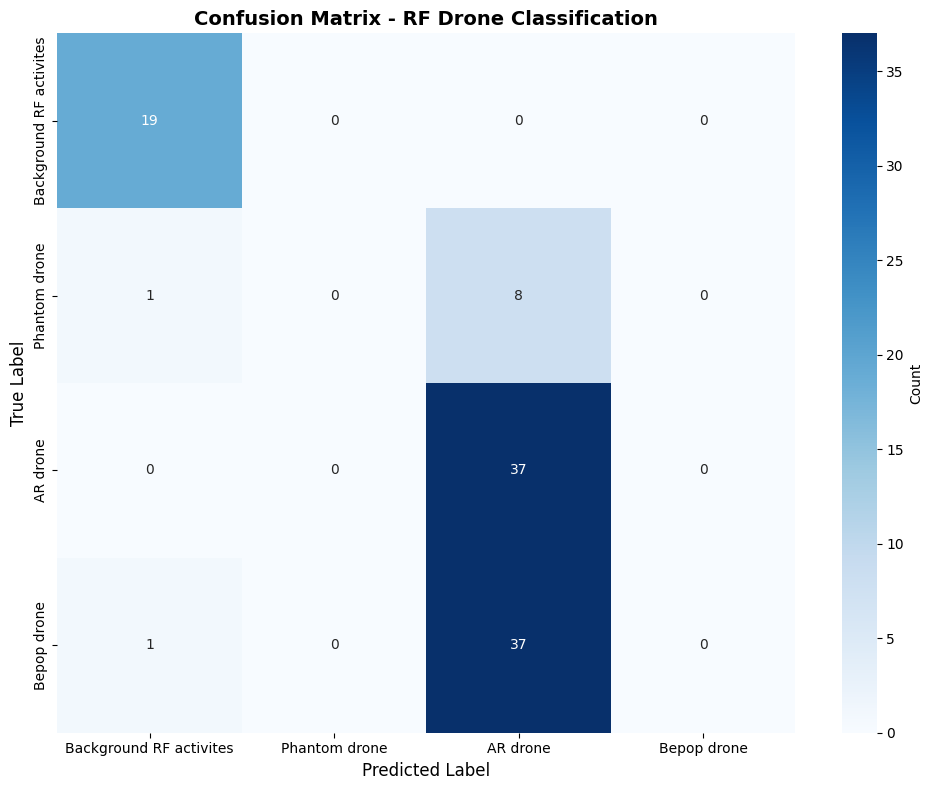

Confusion matrix saved to: /content/drive/MyDrive/DroneRF/models_IMPROVED/confusion_matrix_improved.png


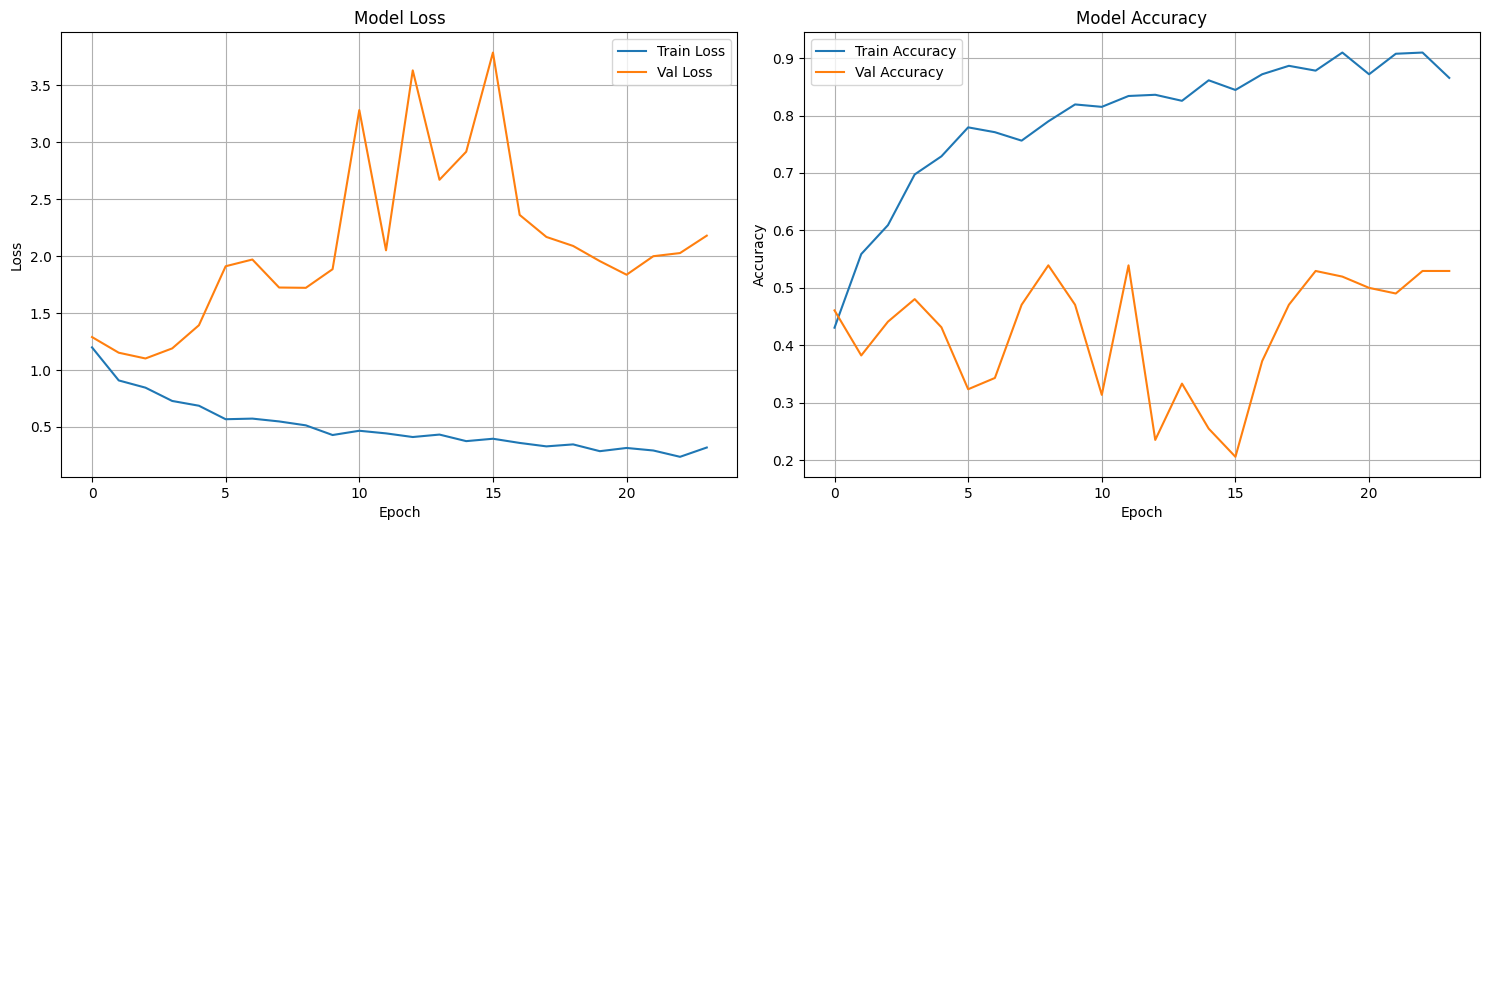

Training history saved to: /content/drive/MyDrive/DroneRF/models_IMPROVED/training_history_improved.png


In [ ]:
# Load best model
best_model = keras.models.load_model(os.path.join(MODEL_SAVE_PATH, 'best_model_improved.keras'))

# Predict
y_pred_proba = best_model.predict([X_time_test, X_freq_test])
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate metrics
from sklearn.metrics import classification_report, accuracy_score

test_accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {test_accuracy*100:.2f}%")

print("\nClassification Report:")
class_names = list(LABEL_MAP.keys())
print(classification_report(y_test, y_pred, target_names=class_names))

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, class_names,
                     os.path.join(MODEL_SAVE_PATH, 'confusion_matrix_improved.png'))

# Plot training history
plot_training_history(history,
                     os.path.join(MODEL_SAVE_PATH, 'training_history_improved.png'))


# Dataset Plotts

Loading dataset...
Loaded dataset:
  X_time shape: (681, 5000, 1)
  X_freq shape: (681, 2501, 1)
  y shape: (681,)


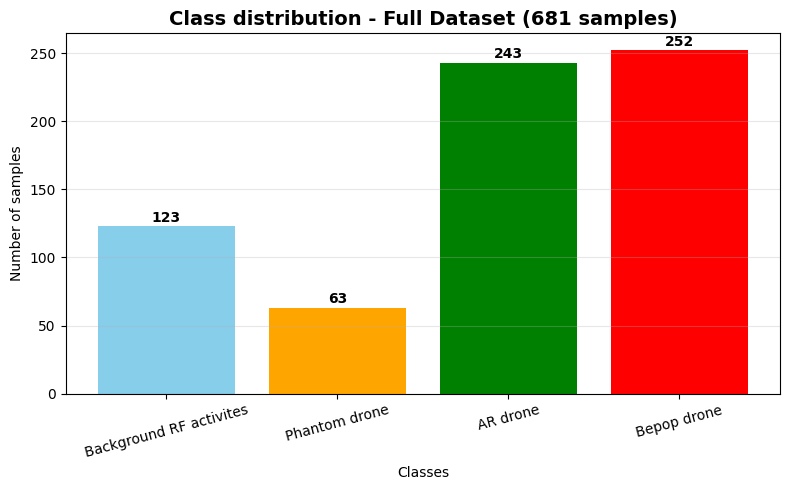


Class distribution:
  Background RF activites: 123 samples (18.1%)
  Phantom drone: 63 samples (9.3%)
  AR drone: 243 samples (35.7%)
  Bepop drone: 252 samples (37.0%)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load saved data
print("Loading dataset...")
X_time_file = "/content/drive/MyDrive/DroneRF/models_IMPROVED/X_time_final.npy"
X_freq_file = "/content/drive/MyDrive/DroneRF/models_IMPROVED/X_freq_final.npy"
y_file = "/content/drive/MyDrive/DroneRF/models_IMPROVED/y_final.npy"

X_time = np.load(X_time_file)
X_freq = np.load(X_freq_file)
y = np.load(y_file)

print(f"Loaded dataset:")
print(f"  X_time shape: {X_time.shape}")
print(f"  X_freq shape: {X_freq.shape}")
print(f"  y shape: {y.shape}")

# Step 2: Class distribution plot
class_names = list(LABEL_MAP.keys())
labels = list(LABEL_MAP.values())

counts = [np.sum(y == lbl) for lbl in labels]

plt.figure(figsize=(8, 5))
bars = plt.bar(class_names, counts, color=['skyblue', 'orange', 'green', 'red'])
plt.title("Class distribution - Full Dataset (681 samples)", fontsize=14, fontweight='bold')
plt.ylabel("Number of samples")
plt.xlabel("Classes")
plt.xticks(rotation=15)
plt.grid(axis="y", alpha=0.3)

# Add value labels on bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nClass distribution:")
for name, count in zip(class_names, counts):
    pct = count / len(y) * 100
    print(f"  {name}: {count} samples ({pct:.1f}%)")


## Training, validation and testign data distribution

/tmp/ipython-input-109005457.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names, rotation=15)
/tmp/ipython-input-109005457.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names, rotation=15)
/tmp/ipython-input-109005457.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names, rotation=15)


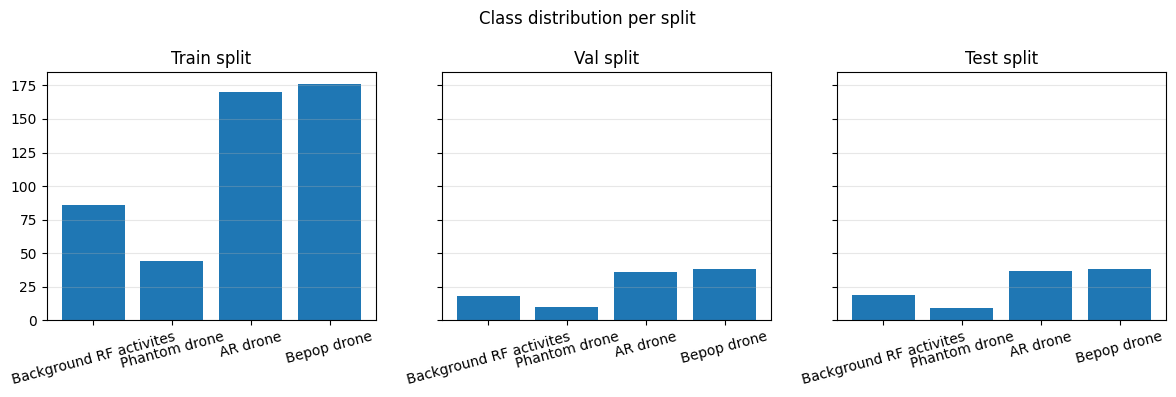

In [ ]:
splits = [("Train", y_train), ("Val", y_val), ("Test", y_test)]
class_names = list(LABEL_MAP.keys())
labels = list(LABEL_MAP.values())

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for ax, (name, y_split) in zip(axes, splits):
    counts = [np.sum(y_split == lbl) for lbl in labels]
    ax.bar(class_names, counts)
    ax.set_title(f"{name} split")
    ax.set_xticklabels(class_names, rotation=15)
    ax.grid(axis="y", alpha=0.3)

fig.suptitle("Class distribution per split")
plt.tight_layout()
plt.show()


## Plot first signal from each class (time domain)

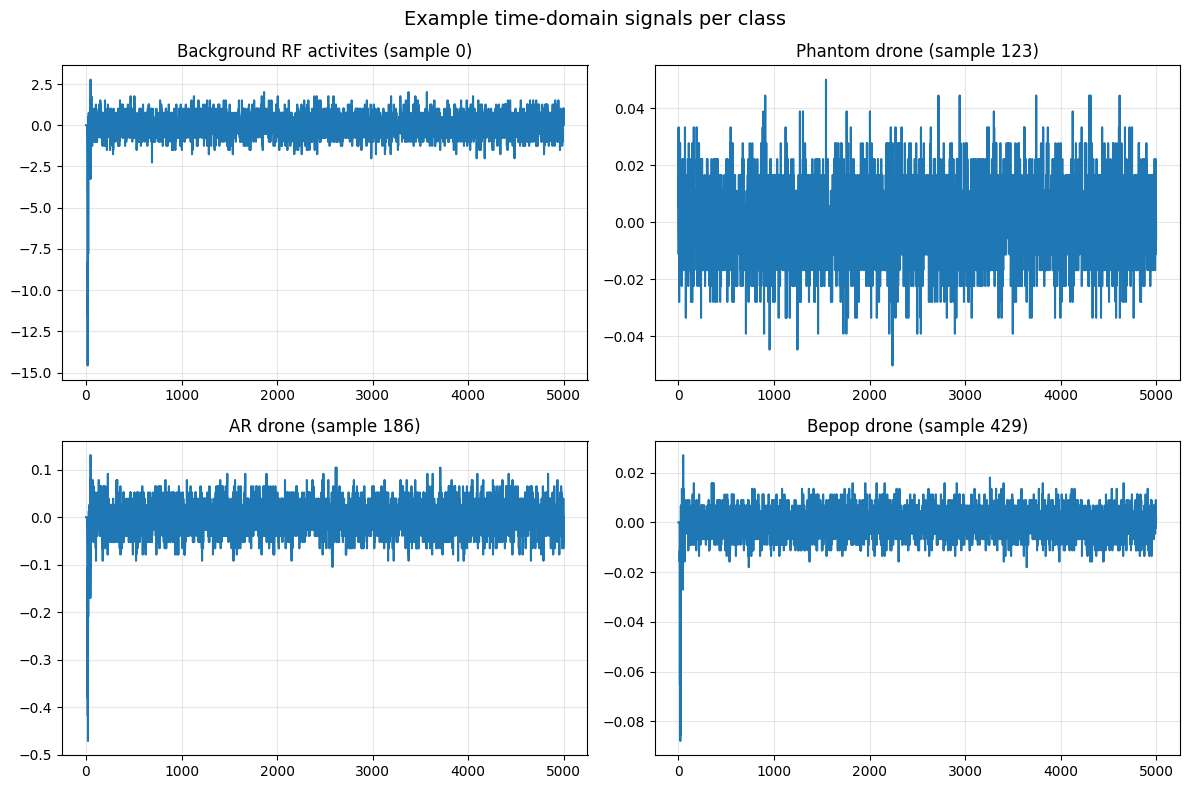

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for i, (class_name, label) in enumerate(LABEL_MAP.items()):
    # Find first sample of this class
    idx = np.where(y == label)[0][0]
    signal = X_time[idx, :, 0]  # Time domain channel

    axes[i].plot(signal)
    axes[i].set_title(f"{class_name} (sample {idx})")
    axes[i].grid(True, alpha=0.3)

plt.suptitle("Example time-domain signals per class", fontsize=14)
plt.tight_layout()
plt.show()


# Check google drive saved files and models

In [ ]:
import os

save_dir = '/content/drive/MyDrive/DroneRF/models_IMPROVED'
files = os.listdir(save_dir)

print("Saved files in your Google Drive:")
for f in sorted(files):
    path = os.path.join(save_dir, f)
    size = os.path.getsize(path) / 1024 / 1024  # MB
    print(f"  {f:<50} ({size:.1f} MB)")

# Test load the model
if 'best_model_improved.keras' in files:
    model = keras.models.load_model(os.path.join(save_dir, 'best_model_improved.keras'))
    print("\n✅ Model loaded successfully!")
    print(f"Model summary:")
    model.summary()
else:
    print("\n❌ Model checkpoint not found - training may not have completed")


Saved files in your Google Drive:
  X_freq_final.npy                                   (6.5 MB)
  X_time_final.npy                                   (13.0 MB)
  best_model_improved.keras                          (1.4 MB)
  chunk_0_X_freq.npy                                 (0.9 MB)
  chunk_0_X_time.npy                                 (1.7 MB)
  chunk_0_y.npy                                      (0.0 MB)
  chunk_1_X_freq.npy                                 (0.9 MB)
  chunk_1_X_time.npy                                 (1.7 MB)
  chunk_1_y.npy                                      (0.0 MB)
  chunk_2_X_freq.npy                                 (0.9 MB)
  chunk_2_X_time.npy                                 (1.7 MB)
  chunk_2_y.npy                                      (0.0 MB)
  chunk_3_X_freq.npy                                 (0.9 MB)
  chunk_3_X_time.npy                                 (1.7 MB)
  chunk_3_y.npy                                      (0.0 MB)
  chunk_4_X_freq.npy               

Model: "RF_CNN_LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ time_input          │ (None, 5000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 2500, 32)  │        256 │ time_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2500, 32)  │        128 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ freq_input          │ (None, 2501, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 2500, 32)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 1251, 32)  │        256 │ freq_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 1250, 64)  │     10,304 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1251, 32)  │        128 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1250, 64)  │        256 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 1251, 32)  │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 1250, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 626, 64)   │     10,304 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 625, 128)  │     24,704 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 626, 64)   │        256 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 625, 128)  │        512 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 626, 64)   │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 625, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping1d_1        │ (None, 625, 64)   │          0 │ dropout_11[0][0]  │
│ (Cropping1D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 625, 192)  │          0 │ dropout_9[0][0],  │
│ (Concatenate)       │                   │            │ cropping1d_1[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 344,046 (1.31 MB)

 Trainable params: 114,468 (447.14 KB)

 Non-trainable params: 640 (2.50 KB)

 Optimizer params: 228,938 (894.29 KB)